## Install required packages


In [49]:
!pip install -q tensorflow_io
!pip install -q seaborn
!pip install -q imbalanced-learn

## Importing libraries

In [50]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import keras_tuner
import librosa
import librosa.display
import IPython.display as ipd
from glob import glob
from tqdm import tqdm
import seaborn as sns
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
from imblearn.under_sampling import ClusterCentroids
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from datetime import datetime
from keras_tuner.tuners import RandomSearch
from keras_tuner import HyperParameters
from keras_tuner.engine.hyperparameters import Int, Choice
from sklearn.metrics import accuracy_score, recall_score

In [51]:
# Set Kaggle Kernel to non-interactive mode and collect file paths
file_paths = []

os.environ['KAGGLE_KERNEL_RUN_INTERACTIVE'] = '0'
for dirname, _, filenames in os.walk('/kaggle/input'):    
    for filename in filenames:
        file_paths.append(os.path.join(dirname, filename))

In [52]:
# check version of TensorFlow
print (tf.__version__)
print (tfio.__version__)

2.12.0
0.31.0


In [53]:
# Set up visualization parameters
sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [54]:
seed = 22
tf.random.set_seed(seed)

# **Importing Data**

The following steps are perfomred below:

Files are read from path
Each file is labeled as either True(1) or False(0)
Data is converted to a dataframe with 2 columns 'filepath' and 'label'.*

In [55]:
# Making a function to label each of the audio files with the plane type and the label type like true or false
def get_label(audio_list):
    """
    Function to label each audio file as True (1) or False (0) based on filename.

    Args:
    audio_list (list): List of audio file paths.

    Returns:
    list: List of tuples containing the audio file path and its corresponding label.
    """  
    
    temp = []

    # loop over the entire audio list and add the aircraft type and label, then save it in another list of tuples for df later
    for i in range(len(audio_list)):
        if audio_list[i][-5] == 'T':
          label = 1
        else:
          label = 0
        t = (audio_list[i] ,  label)
        temp.append(t)   

    return temp       

In [56]:
# Load and preprocess audio data
data = sorted(glob('/kaggle/input/audio-data/Trains_/*.wav', recursive = True))

# Label audio data as True (1) or False (0)
data = get_label(data)

# Create a DataFrame to store file paths and labels
df = pd.DataFrame(data, columns = ['file_path', 'labels'])

print(df.head())

                                    file_path  labels
0   /kaggle/input/audio-data/Trains_/A1-F.wav       0
1   /kaggle/input/audio-data/Trains_/A1-T.wav       1
2  /kaggle/input/audio-data/Trains_/A10-F.wav       0
3  /kaggle/input/audio-data/Trains_/A10-T.wav       1
4  /kaggle/input/audio-data/Trains_/A11-F.wav       0


In [57]:
# Extract file paths and number of files
audio_path = df['file_path']
num_files = len(audio_path)

# Initialise arrays to store audio data and sample rates
audio_data = np.empty(num_files, dtype=object)
samp_rate = np.empty(num_files, dtype=object)

# Load audio files and sample rates
for i, path in enumerate(audio_path):
    audio_, sr = librosa.load(path)
    audio_data[i] = audio_
    samp_rate[i] = sr

# **Preprocessing the Data**

In [58]:
# Resample audio data to a common target sample rate
target_sr =  44100
audio_data_resampled=[]

for audio_dt, s_rate in zip(audio_data,samp_rate):
    audio_data_resmpld = librosa.resample(audio_dt,orig_sr=s_rate,target_sr=target_sr)
    audio_data_normalised = librosa.util.normalize(audio_data_resmpld)
    audio_data_resampled.append(audio_data_normalised)

# Extracting MFCC features from the audio data**

In [59]:
mfcc_features_arr = []
for audio_data_res in tqdm(audio_data_resampled):
    mfcc_features = librosa.feature.mfcc(y=audio_data_res, n_mfcc=40)
    scaled_mfcc = np.mean(mfcc_features.T, axis=0)
    mfcc_features_arr.append(scaled_mfcc)


100%|██████████| 273/273 [00:15<00:00, 18.07it/s]


# Data Visualistion of audio features

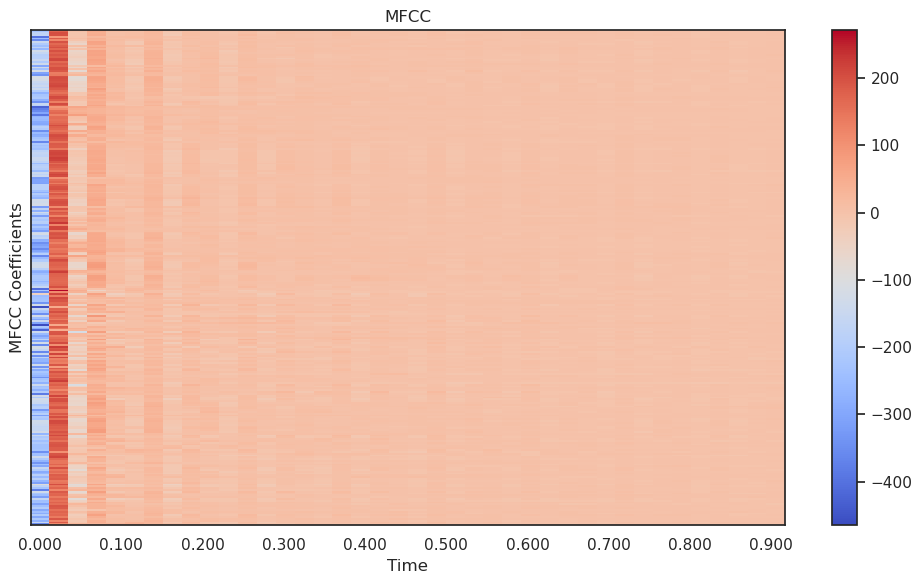

In [60]:
mfcc_features_arr = np.array(mfcc_features_arr)
plt.figure(figsize=(10, 6))
librosa.display.specshow(mfcc_features_arr, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.ylabel('MFCC Coefficients')
plt.tight_layout()
plt.show()

# Splitting the Data

In [61]:
# Stack the 2D MFCC arrays vertically
stacked_mfcc_features = np.vstack(mfcc_features_arr)

# Assign the stacked MFCC features to the DataFrame
df['features'] = list(stacked_mfcc_features)


labels = df['labels']
features = df['features']

X= np.array(features.tolist())
y= np.array(labels.tolist())

In [62]:
# Splitting the Data 80% Train and 30% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=labels, random_state=seed)

In [63]:
# Further split the training data into training and validation sets
X_train_new,X_val,y_train_new,y_val = train_test_split(X_train,y_train,test_size=0.2,stratify=y_train, random_state=seed)

## Handling Imbalanced Data - Undersampling

In [64]:
cluster_centroids = ClusterCentroids(random_state=seed)
X_train_new_under_sampled, y_train_new_under_sampled = cluster_centroids.fit_resample(X_train_new, y_train_new)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Model Development

In [65]:
# Model development
hp = HyperParameters()
def build_model(hp):
    # Build a sequential model with tunable hyperparameters
    model = Sequential()
    model.add(layers.Dense(units=hp.Int('units_1', min_value=100, max_value=300, step=10),
                           activation='relu', input_shape=(40,)))
    model.add(layers.Dropout(rate=hp.Float('dropout_1', min_value=0.3, max_value=0.6, step=0.1)))
    model.add(layers.Dense(units=hp.Int('units_2', min_value=100, max_value=300, step=10),
                           activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout_2', min_value=0.3, max_value=0.6, step=0.1)))
    model.add(layers.Dense(units=hp.Int('units_3', min_value=50, max_value=200, step=10),
                           activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout_3', min_value=0.3, max_value=0.6, step=0.1)))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=tf.keras.metrics.Recall()
)
    return model

## Hyperparameter Tuning

In [66]:
# Hyperparameter tuning
tuner = RandomSearch(
    build_model,
    objective=keras_tuner.Objective('val_recall',direction='max'),
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='Signal Processing',    
    seed=seed
)

In [67]:
# Perform hyperparameter search using undersampled data
tuner.search(X_train_new_under_sampled, y_train_new_under_sampled, epochs=hp.Int('num_epochs', min_value=50, max_value=200, step=10),
             batch_size=hp.Choice('batch_size', values=[2, 8, 16, 32, 64, 128]),
             validation_data=(X_val, y_val))


In [68]:
# Get the best model from the tuner
best_model = tuner.get_best_models(1)[0]

In [69]:
# Display a summary of the best model
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 290)               11890     
                                                                 
 dropout (Dropout)           (None, 290)               0         
                                                                 
 dense_1 (Dense)             (None, 110)               32010     
                                                                 
 dropout_1 (Dropout)         (None, 110)               0         
                                                                 
 dense_2 (Dense)             (None, 180)               19980     
                                                                 
 dropout_2 (Dropout)         (None, 180)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

In [70]:
# Compile the best model
best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=tf.keras.metrics.Recall())

# Set up early stopping to prevent overfitting
callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=50,
    restore_best_weights=True    
)

# Train the best model
start_time =  datetime.now() 
history = best_model.fit(X_train_new_under_sampled, y_train_new_under_sampled,
                         validation_data=(X_val, y_val), verbose=0, callbacks=[callback])

In [71]:
# Measure the training duration
duration = datetime.now() - start_time
print(f'Training completed in time: {duration}')

Training completed in time: 0:00:03.543982


In [72]:
# Prepare test data and evaluate the model on the test set
y_test = np.array(y_test)
y_test = y_test.reshape(-1,1)
y_test.shape


(55, 1)

## Predicting  Test Data

In [73]:
#Evaluate model on unseen test set
y_pred = best_model.predict(X_test)

# Predict classes based on a threshold
threshold = 0.5  

y_pred_classes = np.where(y_pred > threshold, 1, 0)

# Calculate the best validation accuracy achieved during training
best_val_accuracy = max(history.history['val_recall_1'])
print("Best validation accuracy:", best_val_accuracy)


# Evaluate the test accuracy of the best model
test_accuracy= best_model.evaluate(X_test,y_test,verbose=0)
print(f'Test Accuracy:{test_accuracy[1]}')

2/2 [==============================] - 0s 3ms/step
Best validation accuracy: 0.9285714030265808
Test Accuracy:1.0


## Converting the model to TFLite format

In [74]:
# Convert the best model to TFLite format to enable deployment on mobile device
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)